<a href="https://colab.research.google.com/github/DavidJimenez10/Red-Neuronal-desde-0/blob/main/RedNeuronalDesdeCero.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Red neuronal desde 0
Este notebook muestra el proceso de la creacion de una red neuronal densa desde 0, utilizando unicamente numpy y programacion orientada a objetos en python. 

In [ ]:
import numpy as np
seed = 12345
rng = np.random.default_rng(seed)

In [ ]:
!pip install nnfs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import nnfs
from nnfs.datasets import spiral_data
nnfs.init()

## Capas

In [ ]:
class LayerDense():
  """Clase para una capa densa
  """
  def __init__(self, n_inputs, n_neurons, weight_regularizer_l1 = 0, weight_regularizer_l2 = 0, bias_regularizer_l1 = 0, bias_regularizer_l2 = 0):
    """
    n_inputs <int> : numero de entradas de la capa
    n_neurons <int> : numero de neuronas de la capa
    weight_regularizer_l1 <float> : hiperparametro regularizacion l1 (sumatoria valor absoluto pesos)
    weight_regularizer_l2 <float> : hiperparametro regularizacion l2 (sumatoria valor cuadrado pesos) 
    bias_regularizer_l1 <float> : hiperparametro regularizacion l1 (sumatoria valor absoluto sesgo)
    bias_regularizer_l2 <float> : hiperparametro regularizacion l2 (sumatoria valor cuadrado sesgo)
    """
    self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
    self.biases = np.zeros((1, n_neurons))

    self.weight_regularizer_l1 = weight_regularizer_l1
    self.bias_regularizer_l1 = bias_regularizer_l1
    self.weight_regularizer_l2 = weight_regularizer_l2
    self.bias_regularizer_l2 = bias_regularizer_l2

  
  def forward(self, inputs, training):
    """Propagacion hacia adelante de la capa
    self.output <nparray> : la salida de la red, se calcula facilmente en su forma vectorial XW + B
    """

    self.inputs = inputs
    self.output = np.dot(inputs, self.weights) + self.biases

  
  def backward(self, dvalues):
    """Propagacion hacia atras de la capa
    dvalues <np.array> : vector con el valor de las derivadas de la capa proxima
    """
    #Derivada de los pesos y sesgos
    self.dweights = np.dot(self.inputs.T, dvalues)
    self.dbiases = np.sum(dvalues, axis=0, keepdims=True)

    #L1
    #La derivada de L1, al ser una sumatoria de los pesos es -> 1 si w positivo
    #                                                          -1 si w es negativo
    if self.weight_regularizer_l1 > 0:
      dL1 = np.ones_like(self.weights)
      dL1[self.weights < 0] = -1
      self.dweights += self.weight_regularizer_l1 * dL1 

    if self.bias_regularizer_l1 > 0:
      dL1 = np.ones_like(self.biases)
      dL1[self.biases < 0] = -1
      self.dbiases += self.bias_regularizer_l1 * dL1

    #L2
    #La derivada de L1, al ser una sumatoria de los pesos es -> 2 * w
    if self.weight_regularizer_l2 > 0:
      self.dweights += 2 * self.weight_regularizer_l2 * self.weights

    if self.bias_regularizer_l2 > 0:
      self.dbiases += 2 * self.bias_regularizer_l2 * self.biases


    self.dinputs = np.dot(dvalues, self.weights.T)

class LayerDropout():
  """Clase para añadir Dropout una capa
  """

  def __init__(self,dropout_rate):
    """
    dropout_rate <float> : porcentaje de neuronas cuya salida sera 0 durante una propagacion hacia adelante
    """
    self.rate = 1-dropout_rate

  def forward(self,inputs,training):
    """Propagacion hacia adelante
    training <bool> : bandera para estado de entrenamiento. Las neuronas seran desactivadas unicamente en la fase de entrenamiento 
    """
    self.inputs = inputs

    if not training:
      self.output = inputs.copy()
      return

    #Genera un vector de unos con distribucion binomial. donde 
    self.binary_mask = np.random.binomial(1,self.rate,size=inputs.shape)/self.rate

    self.output = inputs * self.binary_mask

  def backward(self,dvalues):
    #La propagacion hacia atras es sencillamente aplicar la mascara a las derivadas de la capa proxima
    self.dinputs = dvalues * self.binary_mask

class LayerInput():
  """Clase de capa Input
  Esta capa representa las entradas de la red
  """
  def forward(self,inputs,training):
  
    self.output = inputs

## Funciones de Activacion

In [ ]:
class ActivationReLU():
  """Clase funcion ReLu
  Esta es la funcion mas comun para las capas ocultas de la red
  """
  def forward(self,inputs,training):
    """Propagacion hacia adelante
    La funcion ReLu solo deja pasar valores positivos, los negativos los hace 0
    """
    self.inputs = inputs
    self.output = np.maximum(0,inputs)

  def backward(self,dvalues):
    """Propagacion hacia atras
    La derivada de la funcion relu es -> 1 valores positivos
                                         0 valores negativos
    """
    self.dinputs = dvalues.copy()
    self.dinputs[self.inputs <= 0] = 0

class ActivationSoftmax():
  """Funcion de activacion SoftMax
  Esta funcion es comun a la salida de la red para problemas de clasificacion. La salida de las neuronas se convierte en una probabilidad 
  """
  def forward(self,inputs,training):
  """el exponencial se utiliza para que todos los valores sean positivos sin perder informacion de los valores negativos
  """
    self.inputs = inputs

    exp_values = np.exp(inputs - np.max(inputs, axis = 1, keepdims = True))

    probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)

    self.output = probabilities

  def backward(self,dvalues):
    
    self.dinputs = np.empty_like(dvalues)#La funcion crea un array pero no lo inicializa 

    for index, (single_output, single_dvalues) in enumerate(zip(self.output,dvalues)):

      single_output = single_output.reshape(-1,1)
      #calculo de la matriz jacobiana de derivadas parciales
      jacobian_matrix = np.diagflat(single_output) - np.dot(single_output, single_output.T)

      self.dinputs[index] = np.dot(jacobian_matrix,single_dvalues)


  def predictions(self,outputs):
    return np.argmax(outputs,axis=1)

## Funciones de perdida

In [ ]:
class Loss():
  """Clase base para funciones de perdida
  """
  def calculate(self,output,y, *, include_regularization = False):
  """
  Devuelve la perdida, esta puede ser o no regularizad. Ademas se acumula los valores para cada epoca de entrenamiento
  """
    sample_losses = self.forward(output,y)
    data_loss = np.mean(sample_losses)
    
    self.accumulated_sum += np.sum(sample_losses)
    self.accumulated_count += len(sample_losses)

    if not include_regularization:
      return data_loss

    return data_loss, self.regularization_loss()

  def regularization_loss(self):
  """
  Devuelve la perdida regularizada del bias y los pesos, bien sea regularizacion de tipo L1 o L2
  """
    regularization_loss = 0

    for layer in self.trainable_layers:
      #L1
      if layer.weight_regularizer_l1 > 0:
        regularization_loss += layer.weight_regularizer_l1 * np.sum(np.abs(layer.weights))

      if layer.bias_regularizer_l1 > 0:
        regularization_loss += layer.bias_regularizer_l1 * np.sum(np.abs(layer.biases))

      #L2
      if layer.weight_regularizer_l2 > 0:
        regularization_loss += layer.weight_regularizer_l2 * np.sum(layer.weights*layer.weights)

      if layer.bias_regularizer_l2 > 0:
        regularization_loss += layer.bias_regularizer_l2 * np.sum(layer.biases*layer.biases)

      return regularization_loss

  def remember_trainable_layers(self,trainable_layers):
    """Guarda las capas "entrenables" para cuando hay regularizacion por dropout
    """
    self.trainable_layers = trainable_layers

  def calculate_accumulated(self, *, include_regularization = False):
  """Devuelve la perdida de la epoca, esta puede ser o no regularizada
  """
    data_loss = self.accumulated_sum/self.accumulated_count

    if not include_regularization:
      return data_loss
    
    return data_loss, self.regularization_loss()

  def new_pass(self):
    """Reinicia la suma y contador de acumulado
    """
    self.accumulated_sum = 0
    self.accumulated_count = 0
  


class LossCategoricalCrossEntropy(Loss):
  """Clase de la funcion de perdida Entropia Cruzada para problemas categoricos
  """
  def forward(self,y_pred,y_real):
    """La funcion devuelve las probabilidades 
    """
    samples = len(y_pred)
    #Se acota el valor predicho para que no sea 0
    y_pred_clipped = np.clip(y_pred,1e-7,1-1e-7)
    #Condicional para diferenciar si y_real tiene one-hot encoding
    if len(y_real.shape) == 1:
      correct_confidence = y_pred_clipped[
                                        range(samples),
                                        y_real]
    elif len(y_real.shape) == 2:
      correct_confidence = np.sum(y_pred_clipped*y_real,
                                  axis=1)

    negative_log_likehoods = np.log(correct_confidence)

    return negative_log_likehoods

  def backward(self,dvalues,y_true):
    """
    dvalues : valores prediccion
    y_true : valores reales
    """
    samples = len(dvalues)
    labels = len(dvalues[0])

    #One-hot encoding
    if len(y_true.shape) == 1:
      y_true = np.eye(labels)[y_true]

    #calculando el gradiente
    self.dinputs = -y_true/dvalues
    #normalizar el gradiente, para evitar que una salida con mas neuronas genere una mayor perdida per se
    self.dinputs = self.dinputs / samples

    

In [ ]:
#Implementando la propagacion hacia atras simplificada cuando utilizo una funcion softmax en la ultima capa y una perdida Categorical Cross Entropy
class ActivationSoftmaxLossCategoricalCrossEntropy():

  def __init__(self):
    self.activation = ActivationSoftmax()
    self.loss = LossCategoricalCrossEntropy()

  def forward(self,inputs,y_true):
    """Propagacion hacia adelante consiste en llamar el metodo forward para la funcion softmax y categorical cross entropy
    """
    self.activation.forward(inputs)
    self.output = self.activation.output
    return self.loss.calculate(self.output,y_true)

  def backward(self,dvalues,y_true):
    """La propagacion hacia atras
    """
    samples = len(dvalues)
    #quitando one-hot encoding del label real
    if len(y_true.shape) == 2:
      y_true = np.argmax(y_true,axis=1)#Obtengo el indice del valor maximo de cada columna
    

    self.dinputs = dvalues.copy()
    #calculo gradiente como el valor de la salida - 1, es decir, el valor del true label
    self.dinputs[range(samples), y_true] -= 1
    #Normalizacion del gradiente, tal como se hace en el categorical cross entropy
    self.dinputs = self.dinputs / samples

## Optimizadores

In [ ]:
class OptimizerSGD():
  """Clase para el optimizador de gradiente estocastico, con posibilidad de añadir momentum y decremento al learning rate
  """
  def __init__(self,learning_rate=1.0,decay=0., momentum = 0.):
  """Constructor Optimizador de Gradiente Estocastico
  learning_rate <float>: tasa de aprendizaje
  decay <float>: constante para el decremento del learning rate
  momentum <float>: importancia dada a los pesos y bias de la iteracion anterior
  """
    self.learning_rate = learning_rate
    self.current_learning_rate = learning_rate
    self.decay = decay
    self.iterations = 0
    self.momentum = momentum

  def pre_update_params(self):
  """Decrementa la tasa de aprendizaje si aplica
  """
    if self.decay:
      self.current_learning_rate = self.learning_rate * (1.0 / (1.0 + self.decay * self.iterations))

  def update_params(self,layer):
  """Actualiza los pesos del modelo
  """
    if self.momentum:
      #inicializacion de la matriz de momentos
      if not hasattr(layer, 'weight_momentums'):
        layer.weight_momentums = np.zeros_like(layer.weights)
        layer.bias_momentums = np.zeros_like(layer.biases)
        
      weight_updates = self.momentum * layer.weight_momentums - self.current_learning_rate * layer.dweights
      layer.weight_momentums = weight_updates 

      bias_updates = self.momentum * layer.bias_momentums - self.current_learning_rate * layer.dbiases
      layer.bias_momentums = bias_updates
    
    else:
      weight_updates = - self.current_learning_rate * layer.dweights
      bias_updates = - self.current_learning_rate * layer.dbiases


    layer.weights += weight_updates
    layer.biases += bias_updates
  
  def post_update_params(self):
  """Aumenta contador iteraciones para decremento de learning rate
  """
    self.iterations += 1

class OptimizerAdaGrad():
  """Clase para el adaptive gradient
  """
  def __init__(self,learning_rate=1.0,decay=0., epsilon = 1e-7):
    """Contructor adaptive gradient
    El adaptive gradient "normaliza" el cambio de en los pesos en busca de utilizar la mayor cantidad de neuronas posibles.
    Adicionalmente se sigue teniendo el mecanismo para decremento del learning rate
    epsilon <float>: Valor mayor a 0, para evitar la division por 0
    """
    self.learning_rate = learning_rate
    self.current_learning_rate = learning_rate
    self.decay = decay
    self.iterations = 0
    self.epsilon = epsilon

  def pre_update_params(self):
    if self.decay:
      self.current_learning_rate = self.learning_rate * (1.0 / (1.0 + self.decay * self.iterations))

  def update_params(self,layer):
    #inicializacion de la matriz de momentos
    if not hasattr(layer, 'weight_cache'):
      layer.weight_cache = np.zeros_like(layer.weights)
      layer.bias_cache = np.zeros_like(layer.biases)
      
    layer.weight_cache += layer.dweights**2

    layer.bias_cache += layer.dbiases**2
    

    layer.weights += -self.current_learning_rate * layer.dweights / (np.sqrt(layer.weight_cache)+self.epsilon)
    layer.biases += -self.current_learning_rate * layer.dbiases / (np.sqrt(layer.bias_cache)+self.epsilon)
  
  def post_update_params(self):
    self.iterations += 1

class OptimizerRMSprop():
  """Clase del optimizador root mean square propagation
  Es una suerte de adagrad con momentum donde la "Normalizacion" de los pesos incluye un termino que es la sumatoria en un momento t-1
  """
  def __init__(self,learning_rate=0.001, decay=0., epsilon=1e-7,rho=0.9):
    """Contructor root mean square propagation
    rho <float>: regula el peso que tiene el momemtum o la normalizacion a la hora de dividir los pesos actuales
    """
    self.learning_rate = learning_rate
    self.current_learning_rate = learning_rate
    self.decay = decay
    self.iterations = 0
    self.epsilon = epsilon
    self.rho = rho
  
  def pre_update_params(self):
    if self.decay:
      self.current_learning_rate = self.current_learning_rate * (1. / (1. + self.decay * self.iterations))

  def update_params(self,layer):
    if not hasattr(layer,'weight_cache'):
      layer.weight_cache = np.zeros_like(layer.weights)
      layer.bias_cache = np.zeros_like(layer.biases)

    layer.weight_cache = self.rho * layer.weight_cache + (1 - self.rho) * layer.dweights**2
    layer.bias_cache = self.rho * layer.bias_cache + (1 - self.rho) * layer.dbiases**2

    layer.weights += -self.current_learning_rate * layer.dweights / (np.sqrt(layer.weight_cache) + self.epsilon)
    layer.biases += -self.current_learning_rate * layer.dbiases / (np.sqrt(layer.bias_cache) + self.epsilon)

  def post_update_params(self):
    self.iterations += 1


class OptimizerAdam():
  """Clase optimizador adaptive momentum
  Este optimizador es muy parecido a root mean square propagation, pero implementa una aceleracion del entrenamiento al inicio para compensar la inicializacion en 0
  """
  def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7, beta_1=0.9, beta_2=0.999):
  """
  beta_1 <float>: parametro para acelerar entrenamiento afectando el termino del momentum o pesos en t-1
  beta_2 <float>: parametro para acelerar entrenamiento afectando el termino del cache o sumatoria de pesos
  """
    self.learning_rate = learning_rate
    self.current_learning_rate = learning_rate
    self.decay = decay
    self.iterations = 0
    self.epsilon = epsilon
    self.beta_1 = beta_1
    self.beta_2 = beta_2
  
  def pre_update_params(self):
    if self.decay:
      self.current_learning_rate = self.current_learning_rate * (1. / (1. + self.decay * self.iterations))

  def update_params(self,layer):
    if not hasattr(layer,'weight_cache'):
      layer.weight_momentums = np.zeros_like(layer.weights)
      layer.weight_cache = np.zeros_like(layer.weights)

      layer.bias_momentums = np.zeros_like(layer.biases)
      layer.bias_cache = np.zeros_like(layer.biases)

    layer.weight_momentums = self.beta_1 * layer.weight_momentums + (1 - self.beta_1) * layer.dweights
    layer.bias_momentums = self.beta_1 * layer.bias_momentums + (1 - self.beta_1) * layer.dbiases
    
    weight_momentums_corrected = layer.weight_momentums / (1 - self.beta_1 ** (self.iterations + 1))
    bias_momentums_corrected = layer.bias_momentums / (1 - self.beta_1 ** (self.iterations + 1))

    layer.weight_cache = self.beta_2 * layer.weight_cache + (1 - self.beta_2) * layer.dweights**2
    layer.bias_cache = self.beta_2 * layer.bias_cache + (1 - self.beta_2) * layer.dbiases**2

    weight_cache_corrected = layer.weight_cache / (1 - self.beta_2 ** (self.iterations + 1))
    bias_cache_corrected = layer.bias_cache / (1 - self.beta_2 ** (self.iterations + 1))

    layer.weights += -self.current_learning_rate * weight_momentums_corrected / (np.sqrt(weight_cache_corrected) + self.epsilon)
    layer.biases += -self.current_learning_rate * bias_momentums_corrected / (np.sqrt(bias_cache_corrected) + self.epsilon)

  def post_update_params(self):
    self.iterations += 1



## Clases metricas

In [ ]:
class Accuracy():
  """Clase para la metrica presicion 
  """
  def calculate(self,predictions,y):
    """Devuelve la presicion promedio del entrenamiento. Ademas acumula los valores de cada iteracion necesarios para poder obtener la presicion por epoca
    """
    comparisons = self.compare(predictions,y)
    accuracy = np.mean(comparisons)

    self.accumulated_sum += np.sum(comparisons)
    self.accumulated_count += len(comparisons)

    return accuracy

  def calculate_accumulated(self):

    accuracy = self.accumulated_sum/self.accumulated_count

    return accuracy

  def new_pass(self):
    self.accumulated_sum = 0
    self.accumulated_count = 0

class AccuracyCategorical(Accuracy):
  """Clase Presicion Categorica
  """
  def __init__(self,*,binary = False):
    self.binary = binary
  
  def init(self,y):
    pass

  def compare(self,predictions,y):
    """Devuelve un vector con los valores conincidente entre la prediccion y el y_real
    """
    if not self.binary and len(y.shape) == 2:
      y = np.argmax(y,axis=1)
    return predictions == y

## Objeto Modelo

In [ ]:
class Model():
  """Clase del modelo, sus metodos permiten definir, entrenar y guardar el modelo
  """
  def __init__(self):
    self.layers = []
    #Este parametro guardara una instancia de la simplificacion de propagacion hacia atras, para softmax y loss categorical cross entropy
    self.softmax_classifier_output = None
  
  def add(self,layer):
  """Esta funcion agrega una capa al modelo
  """
    self.layers.append(layer)

  def set(self, *, loss, optimizer, accuracy):
  """Esta funcion define la perdida, el optimizador y la presicion a utilizar
  """
    self.loss = loss
    self.optimizer = optimizer
    self.accuracy = accuracy

  def train(self,X,y,*,epochs=1,batch_size=None,print_every=1,validation_data=None):
  """Clase para entrenar el modelo
  """
    self.accuracy.init(y)
    
    train_step = 1

    #Condicional para guardar datos de validacion
    if validation_data is not None:
      validation_step = 1

      X_val, y_val = validation_data

    #Condicional para entrenar con batch
    if batch_size is not None:
      train_steps = len(X) // batch_size

      if train_steps * batch_size < len(X):
        train_steps += 1

      if validation_data is not None:
        validation_steps = len(X_val)//batch_size

        if validation_steps * batch_size < len(X_val):
          validation_steps += 1
    
    #Ciclo de epocas de entrenamiento
    for epoch in range(1, epochs + 1):
      
      print(f'epoch: {epoch} ')
      #Reinicio de las clases
      self.loss.new_pass()
      self.accuracy.new_pass()

      #Ciclo para recorrer batchs
      for step in range(train_steps):
        #Definiendo el batch
        if batch_size is None:
          batch_X = X
          batch_y = y
        else:
          batch_X = X[step*batch_size:(step+1)*batch_size]
          batch_y = y[step*batch_size:(step+1)*batch_size]

        #Propagacion hacia adelante
        output = self.forward(batch_X, training = True)

        data_loss, regularization_loss = self.loss.calculate(output,batch_y,include_regularization=True)

        loss = data_loss + regularization_loss

        predictions = self.output_layer_activation.predictions(output)

        accuracy = self.accuracy.calculate(predictions,batch_y)

        #Propagacion hacia atras
        self.backward(output,batch_y)

        self.optimizer.pre_update_params()
        for layer in self.trainable_layers:
          self.optimizer.update_params(layer)
        self.optimizer.post_update_params()

        #Imprime metricas batch
        if not step % print_every or step == train_steps - 1:
          print(f'step: {step}, acc: {accuracy:.3f}, loss: {loss:.3f} (data_loss: {data_loss:.3f}, reg_loss: {regularization_loss:.3f}), lr: {self.optimizer.current_learning_rate}')

      #Metricas epoca
      epoch_data_loss, epoch_regularization_loss = self.loss.calculate_accumulated(include_regularization = True)
      epoch_loss = epoch_data_loss + epoch_regularization_loss
      epoch_accuracy = self.accuracy.calculate_accumulated()

      print(f'training, acc: {epoch_accuracy:.3f}, loss: {epoch_loss:.3f} (data_loss: {epoch_data_loss:.3f} reg_loss: {epoch_regularization_loss:.3f}), lr:{self.optimizer.current_learning_rate}')

      #Validacion datos
      if validation_data is not None:
        self.loss.new_pass()
        self.accuracy.new_pass()
        #Propagacion hacia adelante por batch
        for step in range(validation_steps):
          
          if batch_size is None:
            batch_X = X_val
            batch_y = y_val

          else:
            batch_X = X_val[step*batch_size:(step+1)*batch_size]
            batch_y = y_val[step*batch_size:(step+1)*batch_size]

          output = self.forward(batch_X, training = False)

          self.loss.calculate(output, batch_y)

          predictions = self.output_layer_activation.predictions(output)
          self.accuracy.calculate(predictions, batch_y)

        #Metricas datos validacion
        validation_loss = self.loss.calculate_accumulated()
        validation_accuracy = self.accuracy.calculate_accumulated()

        print(f'validation, acc: {validation_accuracy:.3f}, loss: {validation_loss:.3f}')


  def finalize(self):
  """Esta funcion asigna a todas las capas su respectiva capa previa y proxima
  """
    self.input_layer = LayerInput()

    layer_count = len(self.layers)

    self.trainable_layers = []

    for i in range(layer_count):
      #La capa previa de la primer capa seran los datos de entrada, guardados en la clase input_layer
      if i == 0:
        self.layers[i].prev = self.input_layer
        self.layers[i].next = self.layers[i+1]
      
      elif i < layer_count - 1:
        self.layers[i].prev = self.layers[i-1]
        self.layers[i].next = self.layers[i+1]
      #La ultima capa tendra como capa proxima la clase definida para el calculo de la perdida
      else:
        self.layers[i].prev = self.layers[i-1]
        self.layers[i].next = self.loss
        self.output_layer_activation = self.layers[i]
      
      #Dado que algunas capas pueden hacer referencia a las funciones de activacion, se guardan las capas que si se pueden entrenar
      if hasattr(self.layers[i],'weights'):
        self.trainable_layers.append(self.layers[i])

    self.loss.remember_trainable_layers(
        self.trainable_layers
    )

    #Verifica si el problema es un clasificacion que hace uso de Softmaz y Loss Categorical Cross Entropy
    if isinstance(self.layers[-1],ActivationSoftmax) and isinstance(self.loss, LossCategoricalCrossEntropy):
      self.softmax_classifier_output = ActivationSoftmaxLossCategoricalCrossEntropy()


  def forward(self,X,training):
  """Aplica la propagacion hacia adelante de todas las capas definidas
  """
    self.input_layer.forward(X,training)

    for layer in self.layers:
      layer.forward(layer.prev.output, training)

    return layer.output

  def backward(self,output,y):
  """Aplica la propagacion hacia atras de todas las capas definidas
  """
  #Si el problema es un clasificacion que hace uso de Softmaz y Loss Categorical Cross Entropy
  #Se aplica la propagacion hacia atras simplificada y la salida de esta funcion se pasa como valor de las derivadas de la ultima capa
    if self.softmax_classifier_output is not None:
      self.softmax_classifier_output.backward(output,y)

      self.layers[-1].dinputs = self.softmax_classifier_output.dinputs

      for layer in reversed(self.layers[:-1]):
        layer.backward(layer.next.dinputs)

      return

    self.loss.backward(output,y)

    for layer in reversed(self.layers):
      layer.backward(layer.next.dinputs)

## Entrenando Fashion MNIST

In [ ]:
import os
import urllib
import urllib.request

from zipfile import ZipFile

import cv2
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
URL = "https://nnfs.io/datasets/fashion_mnist_images.zip"
FILE = "fashion_mnist_images.zip"
FOLDER = "fashion_mnist_images"

if not os.path.isfile(FILE):
  print(f'Descargando {URL} y guardando {FILE}...')
  urllib.request.urlretrieve(URL,FILE)

with ZipFile(FILE) as zip_images:
  zip_images.extractall(FOLDER)

print('Archivo descomprimido exitosamente')

Descargando https://nnfs.io/datasets/fashion_mnist_images.zip y guardando fashion_mnist_images.zip...
Archivo descomprimido exitosamente


In [ ]:
image_data = cv2.imread('fashion_mnist_images/train/4/0002.png',cv2.IMREAD_UNCHANGED)
np.set_printoptions(linewidth=200)
print(image_data)

[[  0   0   0   0   0   0   0   0   0   0  90 156 177 182 196 176 117   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   2   0   0 239 253 239 214 226 214 231 245 248   0   0   1   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0  36 241 203 219 192 190 193 207 200 232 135   0   0   2   0   0   0   0   0   0]
 [  0   0   0   0   1   0   0  33 167 227 229 234 228 234 244 215 211 214 208 120   0   0   2   0   0   0   0   0]
 [  0   0   0   0   0   0 157 227 207 207 229 229 232 207 241 227 235 224 203 221 176   0   0   2   0   0   0   0]
 [  0   0   0   0   0  65 218 189 192 187 196 189 188 202 181 195 222 219 190 180 217 125   0   0   0   0   0   0]
 [  0   0   0   0   0 158 213 196 196 191 188 186 179 192 177 192 126 155 193 189 200 166   0   0   0   0   0   0]
 [  0   0   0   0   0 163 217 211 176 188 188 186 183 196 180 191 165 170 216 204 200 195   0   0   0   0   0   0]
 [  0   0   0   0   0 183 215 234 185 182 186 183 184 198 181 185 195 188 203 24

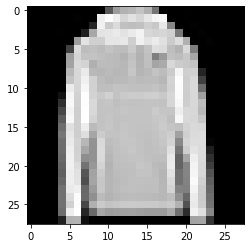

In [ ]:
plt.imshow(image_data,cmap='gray')
plt.show()

In [ ]:
def load_mnist_dataset(dataset,path):

  labels = os.listdir(os.path.join(path,dataset))

  X = []
  y = []

  for label in labels:
    for image in os.listdir(os.path.join(path,dataset,label)):
      image_data = cv2.imread(os.path.join(path,dataset,label,image),cv2.IMREAD_UNCHANGED)

      X.append(image_data)
      y.append(label)

  return np.array(X), np.array(y).astype('uint8')

def create_data_mnist(path):
  X,y = load_mnist_dataset('train',path)
  X_test,y_test = load_mnist_dataset('test',path)

  return X,y,X_test,y_test


In [ ]:
X,y,X_test,y_test = create_data_mnist('fashion_mnist_images')

In [ ]:
#Aleatorizando el orden de los datos
keys = np.array(range(X.shape[0]))
np.random.shuffle(keys)
X=X[keys]
y=y[keys]
#Escalado de las entradas
X = (X.astype('float32') - 127.5) / 127.5
X_test = (X_test.astype('float32') - 127.5) / 127.5
#Flatten de las entradas
X = X.reshape(X.shape[0],-1)
X_test = X_test.reshape(X_test.shape[0],-1)

4


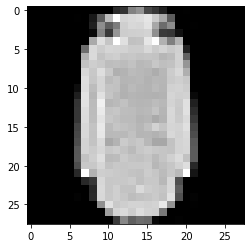

In [ ]:
plt.imshow(X[100].reshape(28,28),cmap='gray')
print(y[100])

In [ ]:
model = Model()
model.add(LayerDense(X.shape[1],128))
model.add(ActivationReLU())
model.add(LayerDense(128,128))
model.add(ActivationReLU())
model.add(LayerDense(128,10))
model.add(ActivationSoftmax())

model.set(loss = LossCategoricalCrossEntropy(), optimizer = OptimizerAdam(decay = 5e-7), accuracy = AccuracyCategorical())

model.finalize()

model.train(X,y,validation_data = (X_test, y_test), epochs=10, batch_size = 128, print_every = 100)

epoch: 1 
step: 0, acc: 0.094, loss: -2.303 (data_loss: -2.303, reg_loss: 0.000), lr: 0.001
step: 100, acc: 0.758, loss: -0.680 (data_loss: -0.680, reg_loss: 0.000), lr: 0.000997478227317151
step: 200, acc: 0.797, loss: -0.653 (data_loss: -0.653, reg_loss: 0.000), lr: 0.00099000066495765
step: 300, acc: 0.812, loss: -0.543 (data_loss: -0.543, reg_loss: 0.000), lr: 0.0009776790139111888
step: 400, acc: 0.820, loss: -0.521 (data_loss: -0.521, reg_loss: 0.000), lr: 0.000960695936222112
step: 468, acc: 0.875, loss: -0.413 (data_loss: -0.413, reg_loss: 0.000), lr: 0.0009466094146227431
training, acc: 0.762, loss: -0.645 (data_loss: -0.645 reg_loss: 0.000), lr:0.0009466094146227431
validation, acc: 0.826, loss: -0.485
epoch: 2 
step: 0, acc: 0.797, loss: -0.441 (data_loss: -0.441, reg_loss: 0.000), lr: 0.0009463874867570986
step: 100, acc: 0.836, loss: -0.508 (data_loss: -0.508, reg_loss: 0.000), lr: 0.0009221247093119007
step: 200, acc: 0.820, loss: -0.516 (data_loss: -0.516, reg_loss: 0.00